<img src="logo_skmob.png" align="left" width="350">

# Privacy

- Repo: [http://bit.ly/skmob_repo](http://bit.ly/skmob_repo)
- Docs: [http://bit.ly/skmob_doc](http://bit.ly/skmob_doc)
- Paper: [http://bit.ly/skmob_paper](http://bit.ly/skmob_paper)

# **Privacy Risk Assessment**

- simulate <font color="blue">privacy attacks</font> 
- assess risk with a worst-case scenario framework

First, we import the necessary modules

In [1]:
from skmob.core.trajectorydataframe import TrajDataFrame
from skmob.privacy import attacks
import pandas as pd

We use a subset of **Geolife** dataset. [Download](https://www.dropbox.com/s/t47813afaz8sb34/geolife.csv.zip?dl=0) and put it in `/data`.

In [2]:
%%time
trjs = TrajDataFrame.from_file(
    './data/geolife_privacy_unprocessed.csv.zip', sep=',')

CPU times: user 1.52 s, sys: 144 ms, total: 1.67 s
Wall time: 1.68 s


The original data can also be loaded using skmob:

In [3]:
#from skmob.io.file import load_geolife_trajectories
#trjs = load_geolife_trajectories("Geolife Trajectories 1.3/Data/").

## Preprocessing

- Generalization and deletion are common ways data holders use to prepare data for sharing/release. 
- Unprocessed data has a granularity that can lead to high levels of privacy risk.

### 1. Trajectory Filtering

In [4]:
%%time
from skmob.preprocessing import filtering
ftrjs = filtering.filter(trjs, max_speed_kmh=500.)

CPU times: user 26.7 s, sys: 455 ms, total: 27.2 s
Wall time: 27.2 s


In [5]:
ftrjs.head()

,Unnamed: 0,datetime,lat,lng,uid
0,485357,2011-10-17 13:33:43,39.971777,116.313195,102
1,485358,2011-10-17 13:33:48,39.971700,116.313113,102
2,485359,2011-10-17 13:33:53,39.971582,116.313028,102
3,485360,2011-10-17 13:33:58,39.971440,116.313080,102
4,485361,2011-10-17 13:34:03,39.971305,116.313150,102


### 2. Trajectory Compression

In [6]:
%%time
from skmob.preprocessing import compression
ctrjs = compression.compress(ftrjs, spatial_radius_km=0.2)

CPU times: user 12 s, sys: 280 ms, total: 12.3 s
Wall time: 12.3 s


In [7]:
ctrjs.head()

,Unnamed: 0,datetime,lat,lng,uid
0,485368,2011-10-17 13:33:43,39.971176,116.313197,102
1,485379,2011-10-17 13:34:43,39.969097,116.313977,102
2,485390,2011-10-17 13:35:38,39.967327,116.315023,102
3,485423,2011-10-17 13:36:33,39.965143,116.315450,102
4,485436,2011-10-17 13:39:13,39.963563,116.316313,102


### 3. Stop Detection

In [8]:
%%time
from skmob.preprocessing import detection
strjs = detection.stops(ctrjs, stop_radius_factor=0.8, \
            minutes_for_a_stop=30.0, spatial_radius_km=0.5, 
            leaving_time=True)

CPU times: user 2.59 s, sys: 33 ms, total: 2.62 s
Wall time: 2.63 s


In [9]:
strjs.head(3)

,Unnamed: 0,datetime,lat,lng,uid,leaving_datetime
0,485509,2011-10-17 13:43:18,39.964063,116.324977,102,2011-10-18 00:45:25
1,487631,2011-10-18 00:57:15,39.978697,116.304820,102,2011-10-19 00:50:41
2,482326,2011-10-19 01:16:56,39.978341,116.303477,102,2011-10-20 22:25:05


### 4. Clustering Trajectories
Clustering helps with generalization, thus reducing privacy risk.

In [10]:
from skmob.preprocessing import clustering
clust_trjs = clustering.cluster(strjs, cluster_radius_km=0.5, min_samples=1)
clust_trjs.head(3)

,Unnamed: 0,datetime,lat,lng,uid,leaving_datetime,cluster
0,485509,2011-10-17 13:43:18,39.964063,116.324977,102,2011-10-18 00:45:25,10
1,487631,2011-10-18 00:57:15,39.978697,116.304820,102,2011-10-19 00:50:41,0
2,482326,2011-10-19 01:16:56,39.978341,116.303477,102,2011-10-20 22:25:05,0


In [11]:
len(pd.unique(clust_trjs["cluster"]))

80

Compute the clusters' centroid and merge with the original data

In [12]:
centroids = clust_trjs.groupby("cluster").mean().reset_index()
centroids = centroids.rename(columns={"uid":"wrong_uid"})
centroids_traj = clust_trjs.rename(columns={"lat":"latitude","lng":"longitude"})
centroids_traj = pd.merge(centroids_traj,centroids,left_on="cluster",right_on="cluster")
privacy_trjs = centroids_traj[["datetime","lat","lng","uid"]]

Save the processed data to save time

In [13]:
privacy_trjs.to_csv("data/geolife_privacy.csv",index=False)

In [14]:
privacy_trjs = TrajDataFrame.from_file("data/geolife_privacy.csv")

## Setting up attacks
Each attack model is a class inheriting from the `Attack` class. 

To instatiante an attack model by specifying `knowledge_length`, i.e., the length of the background knowledge.

In [15]:
at = attacks.LocationFrequencyAttack(knowledge_length=2,tolerance=0.5)

To compute privacy risk for all users, use method `assess_risk`. 

In [16]:
r2 = at.assess_risk(privacy_trjs, show_progress=True)

computing risk: 100%|██████████| 20/20 [00:51<00:00,  2.31s/it]


In [17]:
r2.head()

,uid,risk
0,102,0.500000
1,103,1.000000
2,104,1.000000
3,105,1.000000
4,132,0.333333


Risk assessment is both data dependent and application dependent. Let's suppose that we decide that a risk less than 1 is acceptable.

In [18]:
r2[r2["risk"] < 1]

,uid,risk
0,102,0.500000
4,132,0.333333
5,133,0.250000
7,135,0.500000
8,150,0.333333
10,156,0.333333
12,158,0.500000
13,159,0.500000
14,160,0.500000
15,161,0.500000


## Assessment options
change the size of the background knowledge with `knowledge_length`, or instantiate a new attack model.

In [19]:
at.knowledge_length = 3
r3 = at.assess_risk(privacy_trjs, show_progress=True)

computing risk: 100%|██████████| 20/20 [00:57<00:00,  2.58s/it]


We can now see that risk changes. We can thus perform a systematic analysis of risk changing the background knowledge.

In [20]:
r3[r3["risk"] < 1]

,uid,risk
4,132,0.500000
5,133,0.333333
8,150,0.500000
10,156,0.333333
13,159,0.500000
15,161,0.500000
16,166,0.200000
19,169,0.500000


- Not all background knowledge instances may be evaluated during the assessment: if an instance has risk 1.0, the following combinations are discarded.

- To show all possible instances, use the `force_instances` parameter (requires long times and high memory usage).

- Combinations are identified by `instance` and elements in the instance by `instance_elem`. 

- Use the option `targets` to specify the subset of the individuals on which to perform privacy risk assessment. 

- To check on the progress, we can use the `show_progress` attribute

In [21]:
inst = at.assess_risk(privacy_trjs, force_instances=True, 
                      targets=list(privacy_trjs.uid.unique()[:1]), show_progress=True)
inst.head()

computing risk: 100%|██████████| 1/1 [00:13<00:00, 13.60s/it]


,lat,lng,datetime,uid,instance,instance_elem,prob
0,102.0,37.068910,114.098359,1.0,1,1,0.166667
1,102.0,37.419688,114.507235,1.0,1,2,0.166667
2,102.0,37.774137,115.553705,1.0,1,3,0.166667
3,102.0,37.068910,114.098359,1.0,2,1,0.166667
4,102.0,37.419688,114.507235,1.0,2,2,0.166667


Complexity is dominated by the number of combinations, which depends on:
- length of the background knowledge
- average length of each user's trajectory. 

\begin{equation*}
\mathcal{O} \Bigl(  \binom{l}{k} |T|  matching \Bigr)
\end{equation*}

- $l$ is the length of the current trajectory considered
- $k$ is the background knowledge length
- $T$ is the set of all target trajectories
- $matching$ stands for the cost of the matching operation between each combination and the data.

## Attack Models
these are eight attack models, each with a different background knowledge:
 - `LocationAttack`: uses the locations visited.
 - `LocationSequenceAttack`: uses the locations visited with information about the order of visit
 - `LocationTimeAttack`: uses the locations visited and the time of visit. A precision for the time can be specified

- `UniqueLocationAttack`: uses the unique locations visited, i.e., disregarding repeated visits to a same location. It operates on frequency vectors
- `LocationFrequencyAttack`: uses the unique locations visited and the frequency with which they were visited. It operates on frequency vectors
- `LocationProbabilityAttack`: uses the unique locations visited and the probability with which they were visited. It operates on probability vectors

 - `LocationProportionAttack`: uses the unique locations visited and the relative proportion of the frequencies of visit. It operates on frequency vectors
 - `HomeWorkAttack`: uses the two most visited locations

## Understading the matching mechanic
In the data folder of the scikit-mobility github, you can find a simple toy dataset that can be used to better understand the mechanics of every attack

In [22]:
toy = TrajDataFrame.from_file(filename="./data/privacy_toy.csv")

In [23]:
toy.head()

,lat,lng,datetime,uid
0,43.843014,10.507994,2011-02-03 08:34:04,1
1,43.544270,10.326150,2011-02-03 09:34:04,1
2,43.708530,10.403600,2011-02-03 10:34:04,1
3,43.779250,11.246260,2011-02-04 10:34:04,1
4,43.843014,10.507994,2011-02-03 08:34:04,2


In [24]:
at = attacks.LocationAttack(knowledge_length=2)
r_toy = at.assess_risk(toy, targets=[1], force_instances=True)
r_toy

,lat,lng,datetime,uid,instance,instance_elem,prob
0,43.843014,10.507994,2011-02-03 08:34:04,1,1,1,0.250000
1,43.544270,10.326150,2011-02-03 09:34:04,1,1,2,0.250000
2,43.843014,10.507994,2011-02-03 08:34:04,1,2,1,0.250000
3,43.708530,10.403600,2011-02-03 10:34:04,1,2,2,0.250000
4,43.843014,10.507994,2011-02-03 08:34:04,1,3,1,0.250000
5,43.779250,11.246260,2011-02-04 10:34:04,1,3,2,0.250000
6,43.544270,10.326150,2011-02-03 09:34:04,1,4,1,0.250000
7,43.708530,10.403600,2011-02-03 10:34:04,1,4,2,0.250000
8,43.544270,10.326150,2011-02-03 09:34:04,1,5,1,0.333333
9,43.779250,11.246260,2011-02-04 10:34:04,1,5,2,0.333333


The background knowledge for a Location Attack consists of locations, with no information about the order of visits to it.
If we look at the first background knowledge instance, the information used is then:

In [25]:
from skmob.utils import constants
toy[toy[constants.UID] == 1][[constants.LATITUDE, 
                                    constants.LONGITUDE]].iloc[0:2]

,lat,lng
0,43.843014,10.507994
1,43.544270,10.326150


We can clearly see that the matches for this instance are individuals 1, 2, 3 and 6

In [26]:
toy[toy[constants.UID].isin([1,2,3,6])]

,lat,lng,datetime,uid
0,43.843014,10.507994,2011-02-03 08:34:04,1
1,43.544270,10.326150,2011-02-03 09:34:04,1
2,43.708530,10.403600,2011-02-03 10:34:04,1
3,43.779250,11.246260,2011-02-04 10:34:04,1
4,43.843014,10.507994,2011-02-03 08:34:04,2
5,43.708530,10.403600,2011-02-03 09:34:04,2
6,43.843014,10.507994,2011-02-04 10:34:04,2
7,43.544270,10.326150,2011-02-04 11:34:04,2
8,43.544270,10.326150,2011-02-03 08:34:04,3
9,43.708530,10.403600,2011-02-03 09:34:04,3


## Additional parameters for attacks

Some attacks, such as `LocationTimeAttack`, need additional parameters. Find in the <a href="https://scikit-mobility.github.io/scikit-mobility/reference/privacy.html">doc</a> details of each attack. Let's see an example of a powerful attack.

`LocationTimeAttack` uses the informaton about the location visited and the time of visit 

In [27]:
# time_precision is the precision with witch to consider the temporal information 
at = attacks.LocationTimeAttack(knowledge_length=2, time_precision="Day")

In [28]:
r_time = at.assess_risk(privacy_trjs)

In [29]:
r_time.head()

,uid,risk
0,102,1.0
1,103,1.0
2,104,1.0
3,105,1.0
4,132,1.0


In [30]:
r_time[r_time["risk"] < 1]

,uid,risk


We can see that, for powerful attacks, risk can be really high, despite our efforts to generalize trajectories.

## Visualizing and understanding risk
Risk may be visualized in many different ways. A very simple and intuitive way is a cumulative distribution function.

In [31]:
import numpy as np
import matplotlib.pyplot as plt

In [32]:
results = [r2,r3,r_time]
colors = ["red","blue","green"]
styles = ["-","--",":"]
labels = ["Frequency k2", "Frequency k3", "Location Time k2 Hour"]
fontsize = 20

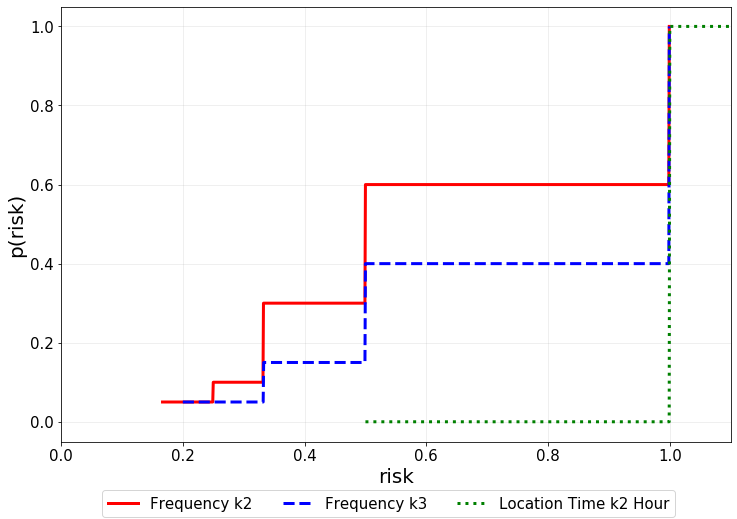

In [33]:
plt.figure(figsize=(12,8))
for i in range(0,len(results)):
    data = results[i]["risk"].tolist()
    values, base = np.histogram(data, bins=1000)
    cumulative = np.cumsum(values)
    plt.plot(base[:-1],cumulative/len(data), c=colors[i], label=labels[i], linestyle=styles[i],linewidth=3)
plt.xlim(0,1.1)
plt.xlabel("risk",size=fontsize)
plt.ylabel("p(risk)", size=fontsize)
plt.xticks(size=fontsize-5)
plt.yticks(size=fontsize-5)
plt.grid(alpha=0.25)
plt.figlegend(labels, loc = 'lower center',bbox_to_anchor=(0.45, -0.01), ncol=3,  fontsize = fontsize-5, labelspacing=0. )
plt.show()

# Conclusions
- Evaluating risk is not an immediate task. It depends on the kind of data you are using, on the purpose of your analysis, on the properties you want to maintain.
- Privacy risk has to be explored thoroughly with different attack models and different configurations
- For mobility data preprocessing data is paramount. Risk assessment can be performed with diversely processed data in order to understand the "best" format for release